# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [172]:
# Импорт библиотек
import numpy as np  # для работы с массивами
import pandas as pd  # для работы с DataFrame
import seaborn as sns  # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt  # для построения графиков

%matplotlib inline


Прочитаем исходные данные:

In [173]:
data = pd.read_csv('./data/unconv.csv')
data.head()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [174]:
data.describe()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

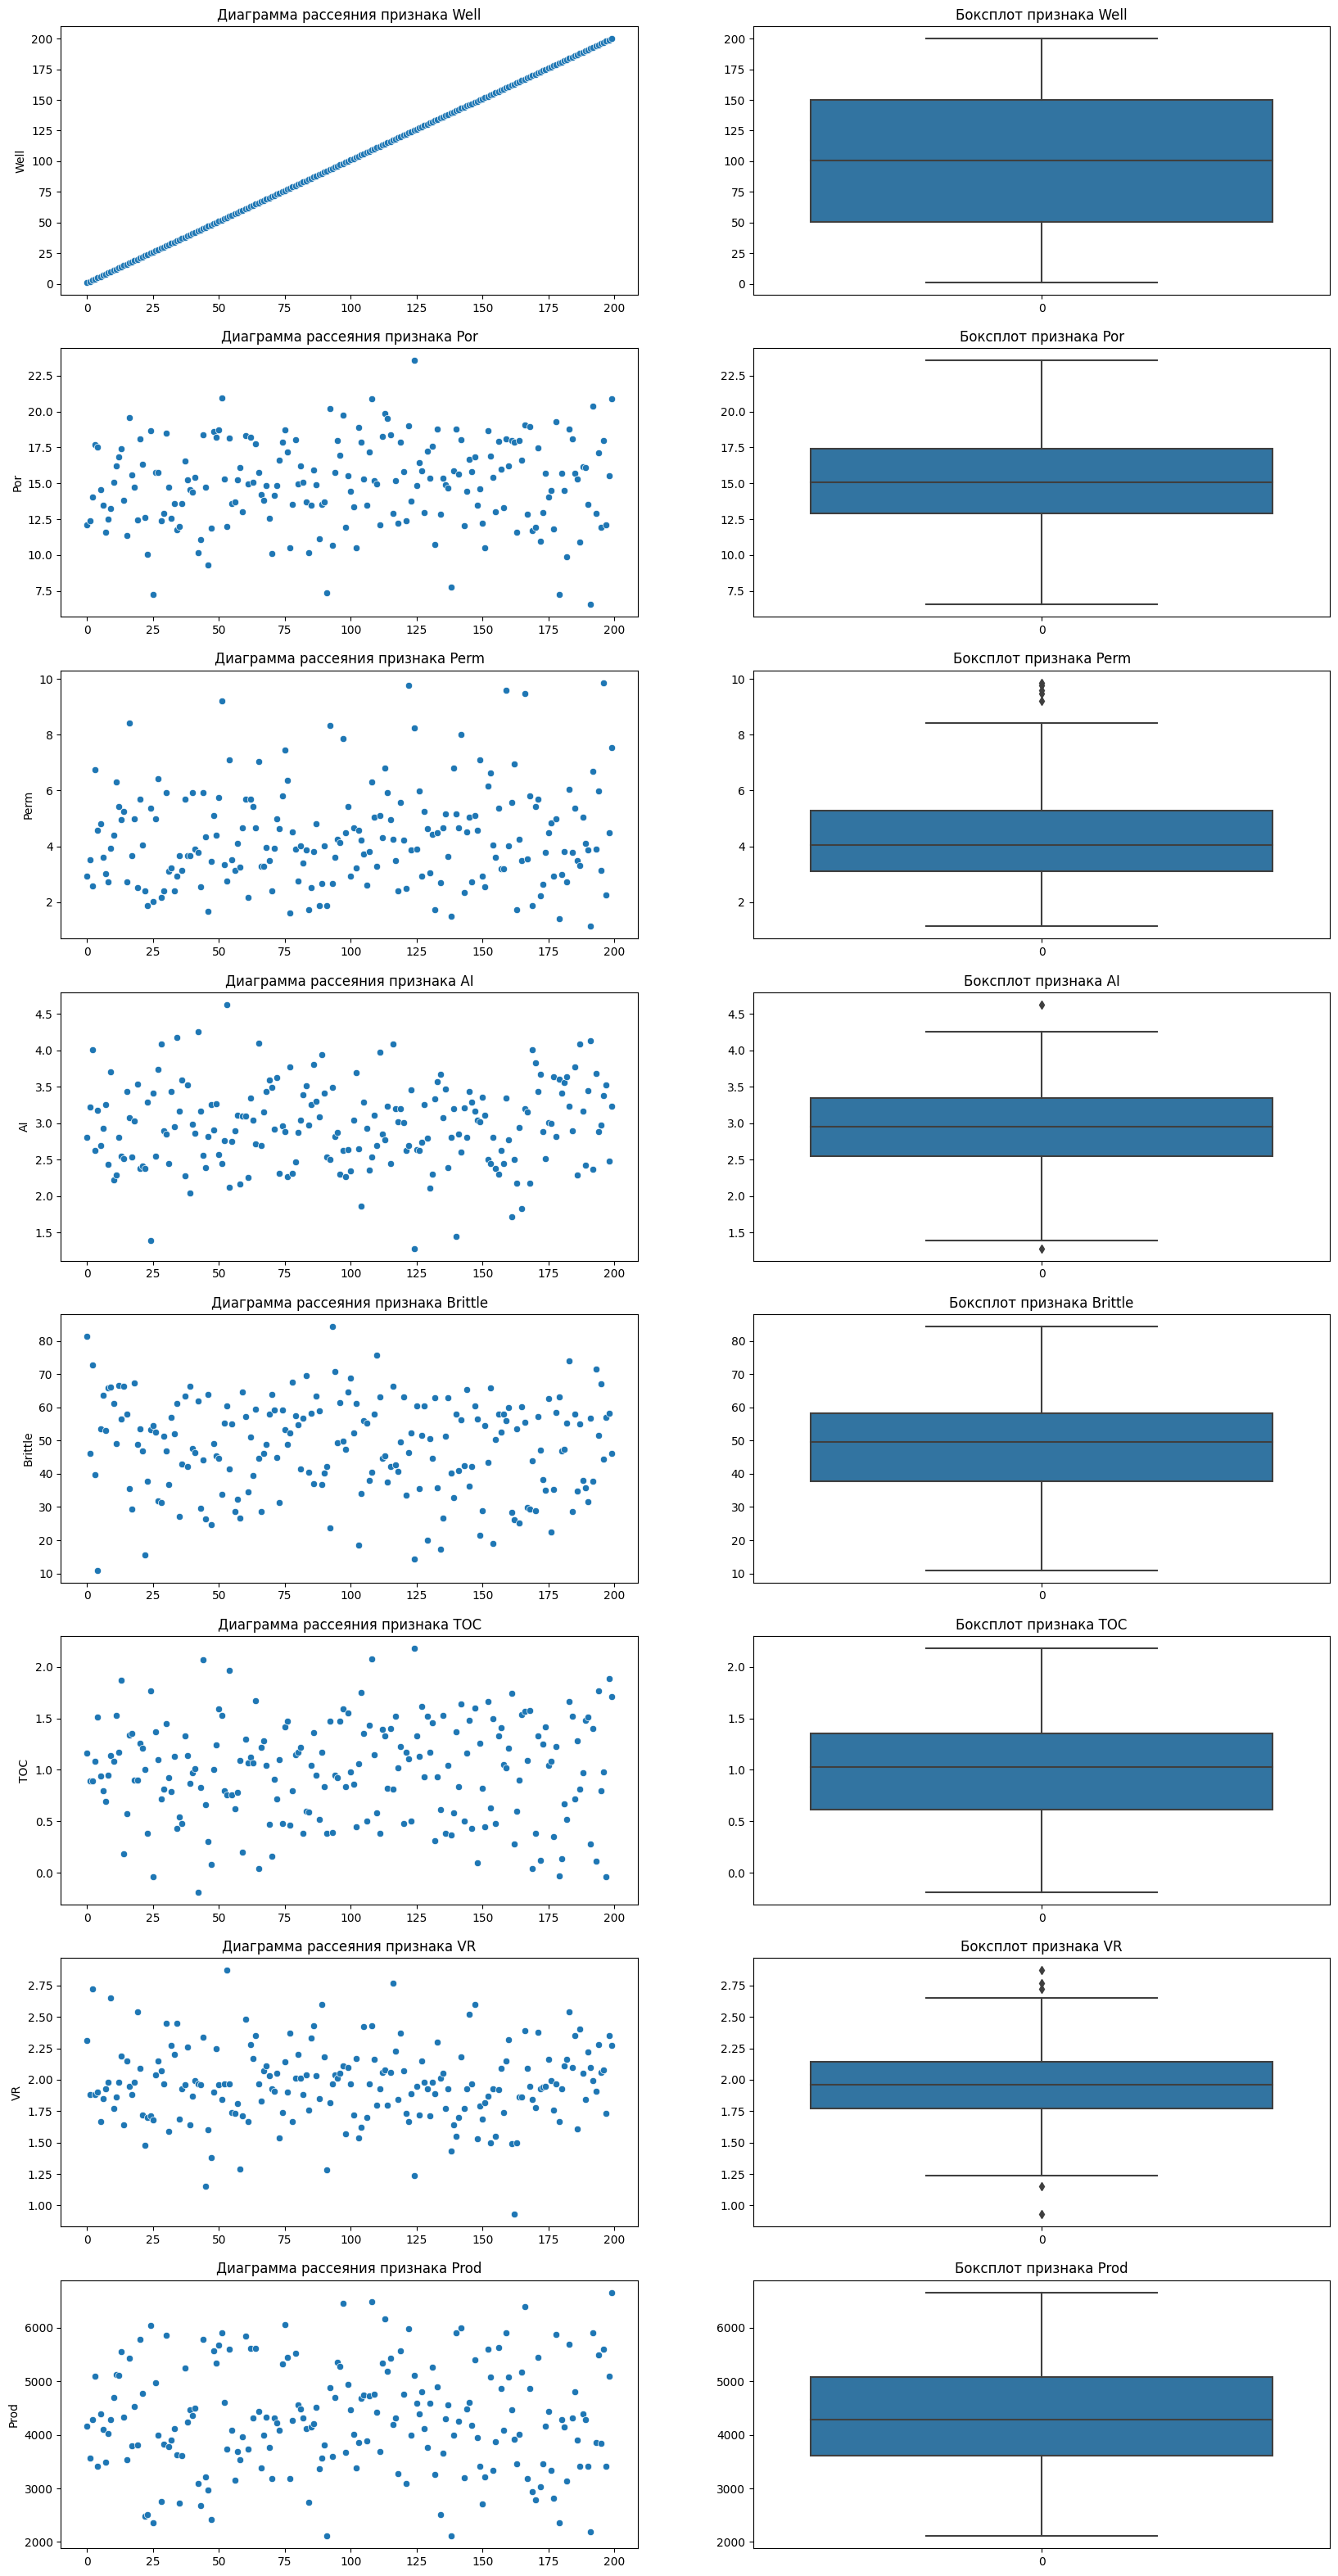

In [175]:
fig, axes = plt.subplots(len(data.columns), 2, figsize=(20, 40))

for number, feat in enumerate(data.columns.to_list()):
    scatter = sns.scatterplot(data=data[feat], ax=axes[number][0])
    scatter.set_title(f'Диаграмма рассеяния признака {feat}')
    
    box = sns.boxplot(data=data[feat], ax=axes[number][1])
    box.set_title(f'Боксплот признака {feat}')


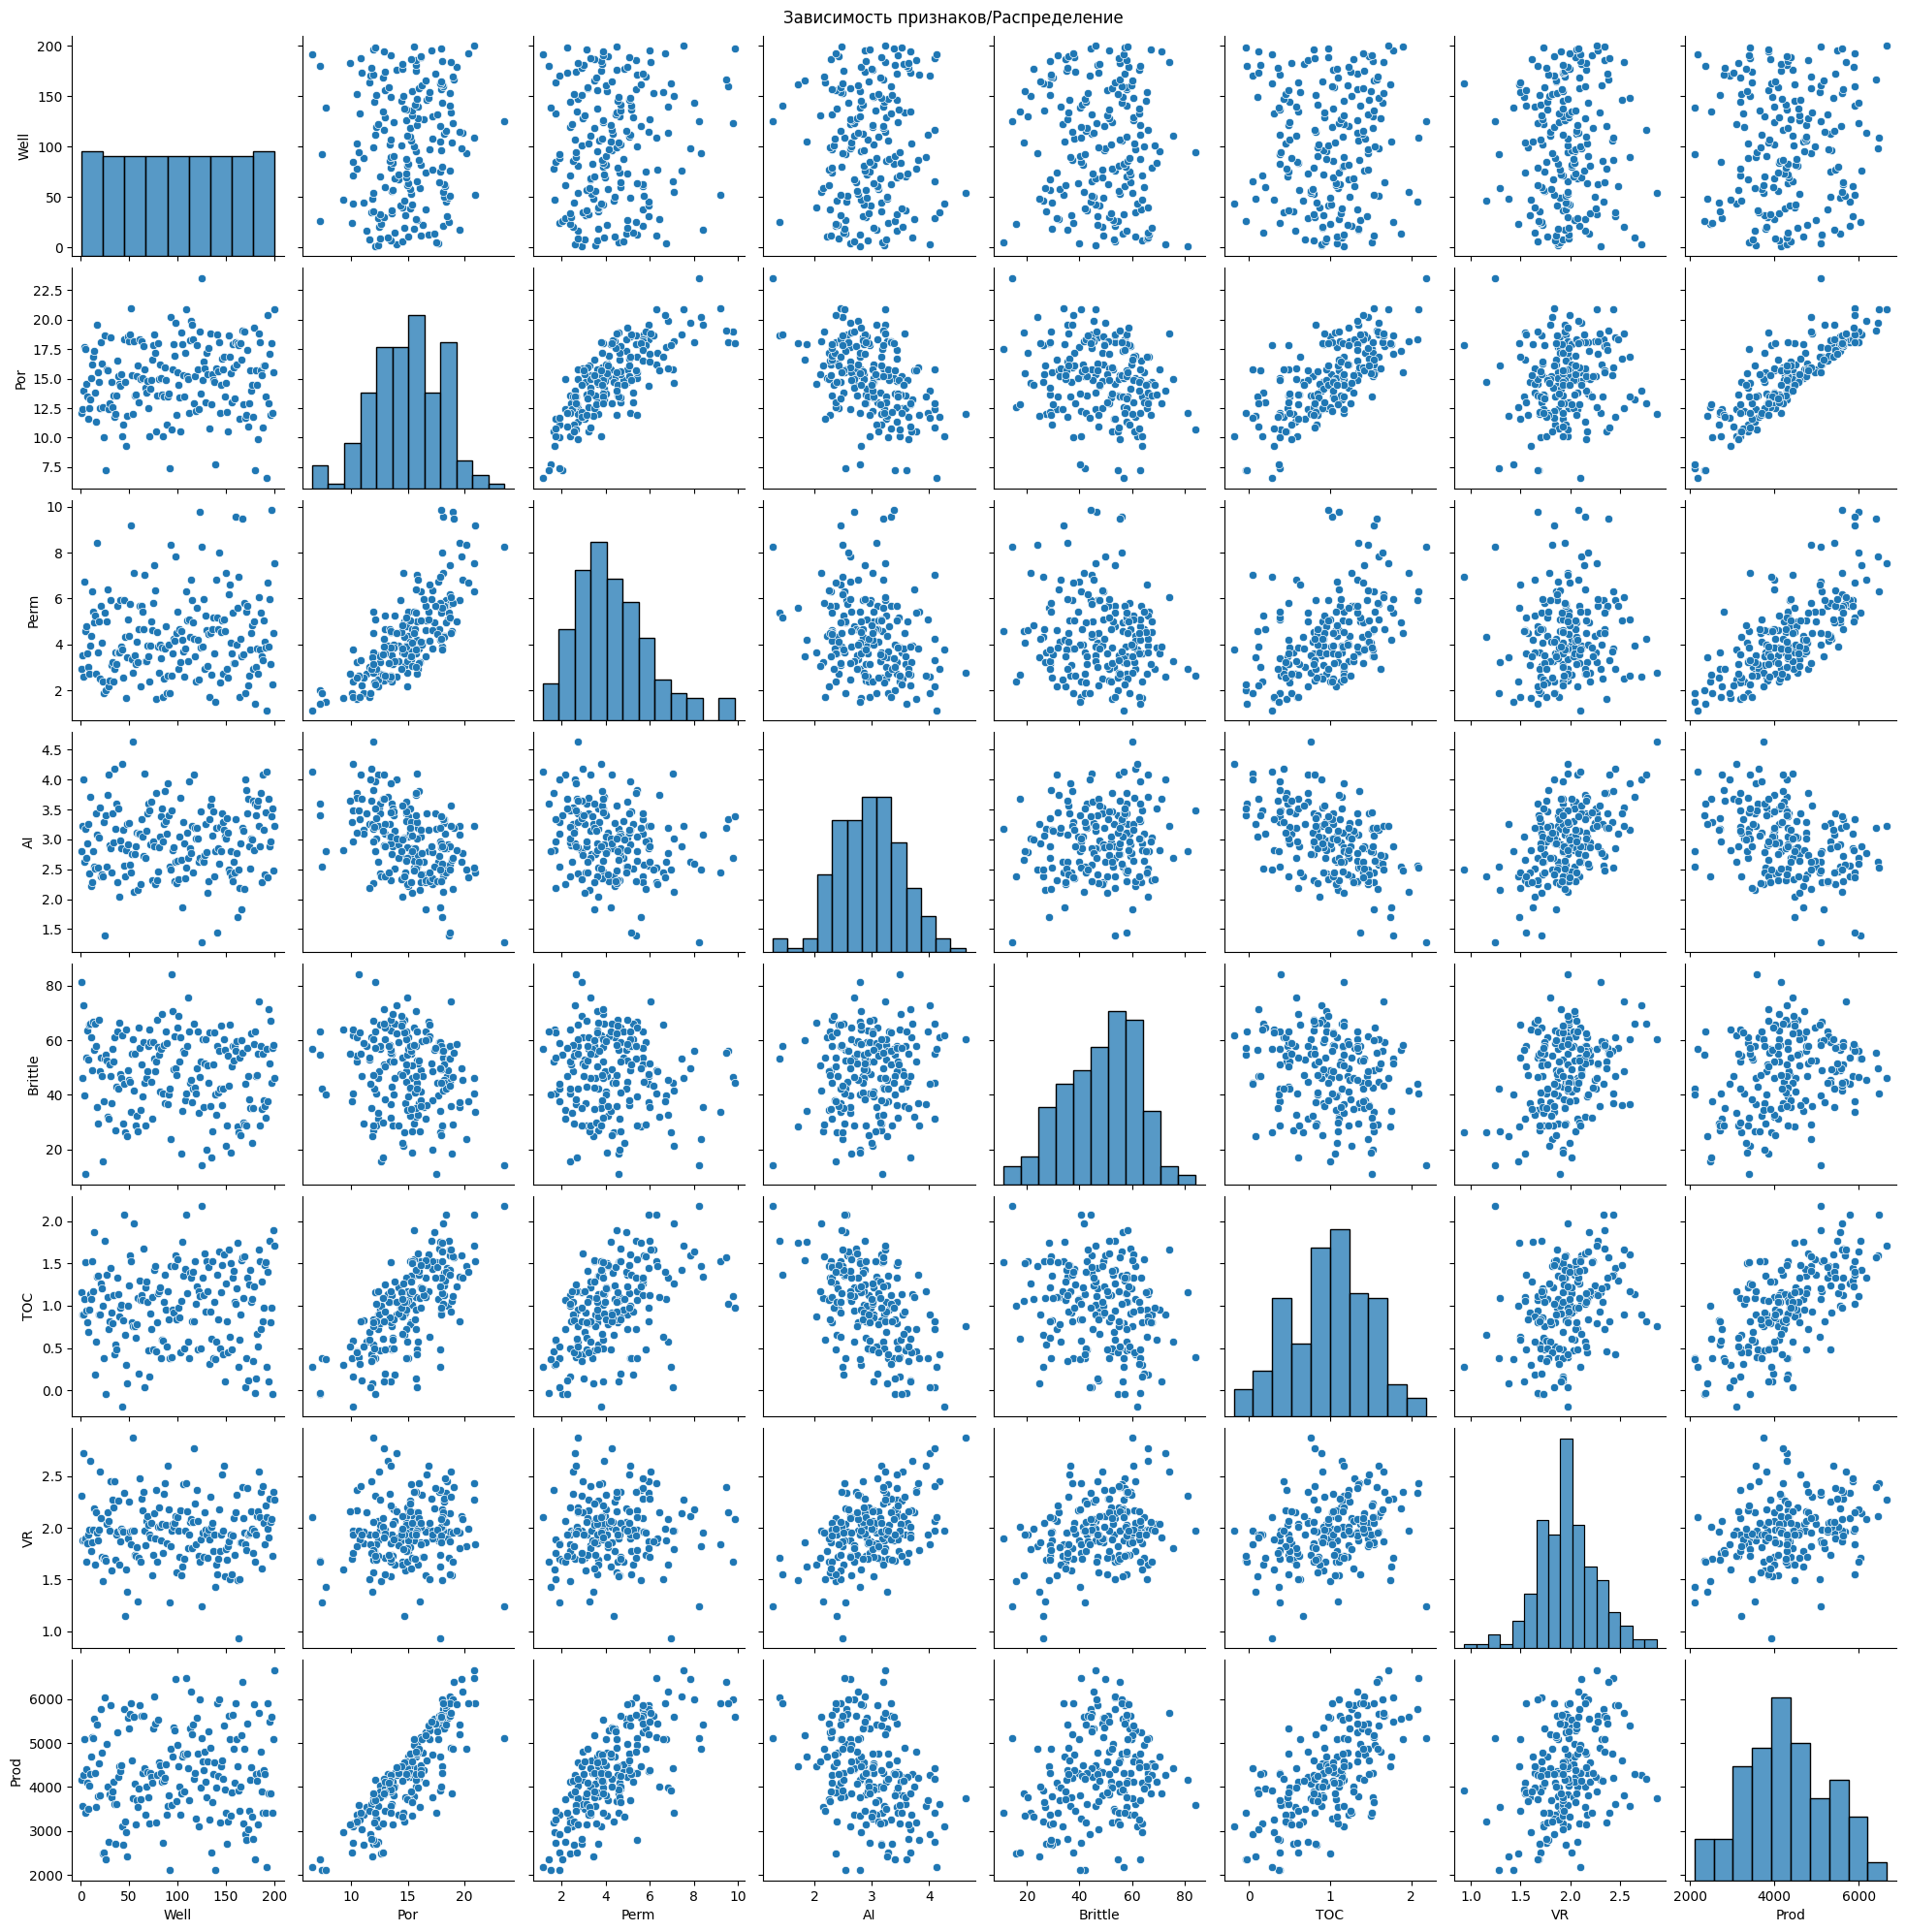

In [176]:
pair = sns.pairplot(data)
pair.fig.suptitle('Зависимость признаков/Распределение', y=1);

> Умеренная дисперсия признаков (достаточно высокая на целевой переменной), визуально есть незначительные выбросы (что так же отражено на боксплотах), дисперия 'Well' четко говорит о нем как о признаке-индексе

> Нормальное/ близкое к нормальному распределению признаков, 'Perm'- логнормальное (для поиска выбросов по данному фиту нужно будет логарифмироать)

> Прямая зависимость признаков (кроме признака AI), с выраженной сильной связью нескольких из них (высокая плотность точек) с целевой переменной, а так же возможностью мультиколлинеарности

---

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Ранг матрицы: 8
Определитель матрицы: 0.00073


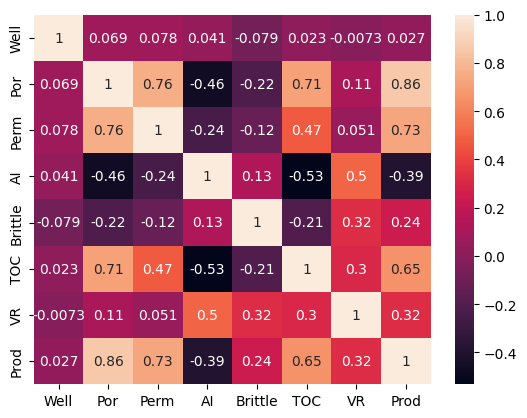

In [177]:
corr_matrix = data.corr()  # корреляционная матрица
rk = np.linalg.matrix_rank(corr_matrix)  # ранг матрицы
det_matrix = np.linalg.det(corr_matrix).round(5)  # определитель матрицы
print(f'Ранг матрицы: {rk}\nОпределитель матрицы: {det_matrix}')

sns.heatmap(corr_matrix, annot=True);


> Наибольшей корреляцией с целевой переменной обладают следующие факторы:
* Por = 0.86
* Perm = 0.73
* Toc = 0.65
> Определитель матрицы очень близок к нулю, что говорит о вырожденности, а следовательно классическая МНК-модель линейной регрессии не применима.
> Наличествует мультиколлинеарность между следующими признаками:
* Por и Perm
* Por и Toc

---

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [178]:
X = np.column_stack((np.ones(200), data.drop(['Prod'], axis=1)))
y = data['Prod']

w_hat = np.linalg.inv(X.T @ X) @ X.T @ y
factors = ['w_0', 'Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
print(factors := dict(zip(factors, w_hat.round())))


{'w_0': -1232.0, 'Well': 0.0, 'Por': 230.0, 'Perm': 116.0, 'AI': -365.0, 'Brittle': 25.0, 'TOC': -78.0, 'VR': 785.0}


> В данных присутсвтуют неинформативные признаки, характеризующиеся нулевым коэффициентом, в данном случае признак Well (который по-сути является аналогом индекса).
> Интерпретация коэффициентов (на примере признаков Por и AI):
* Увеличение Por на единицу, приведет к увеличению прогноза на 230 единиц (прямая связь)
* Увеличение AI на единицу, приведет к уменьшению прогноза на 365 единиц (обратная связь)

---

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [179]:
new_data = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
}

prod_new = 4748.315024  # фактическая выработка газа на тестовой скважине

new_vector = np.array([1] + [i for i in new_data.values()])
prediction_new = new_vector @ w_hat  # спрогнозированная выработка газа

mae_new = np.mean(np.abs(prod_new - prediction_new))
mape_new = np.mean(np.abs(prod_new - prediction_new)/np.abs(prod_new)) * 100

y_pred = X @ w_hat  # прогноз на тренировочной выборке

mae_train = np.mean(np.abs(y - y_pred))
mape_train = np.mean(np.abs(y - y_pred)/np.abs(y)) * 100

print(f'MAE на тестовой скважине: {mae_new.round()}')
print(f'MAPE на тестовой скважине: {mape_new.round(1)}\n')

print(f'MAE на обучающей выборке: {mae_train.round()}')
print(f'MAPE на обучающей выборке: {mape_train.round(1)}')


MAE на тестовой скважине: 25.0
MAPE на тестовой скважине: 0.5

MAE на обучающей выборке: 154.0
MAPE на обучающей выборке: 3.6


> В данном случае более информативной для нас выступит метрика MAE, т.к. процентное соотношение не столь драматично. Из сравнения MAE на обучающей и тестовой (в нашем случае новой размеченной строкой) мы можем сделать вывод о вероятном переобучении модели (большом разбросе модели), т.к. разница метрик весьма существенна и характерно хуже на тестовой выборке. Данная картина наводит на мысль о необходимости регуляризации для увеличения смещения модели при уменьшении разброса, для получения адекватного прогноза на новых данных.

---

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [180]:
corr_factor_check = pd.concat(
    [corr_matrix['Prod'].round(3), pd.Series(factors)], axis=1)  # объединим корреляционную матрицу и коэфициенты модели

corr_factor_check.rename(
    columns={'Prod': 'Correlation', 0: 'Model_coef'}, inplace=True)  # переименуем фиты для наглядности

# сбросим свободный коэфициент w_0 и целевую переменную
corr_factor_check.drop(['Prod', 'w_0'], inplace=True)

display(corr_factor_check)


,Correlation,Model_coef
Well,0.027,0.0
Por,0.862,230.0
Perm,0.727,116.0
AI,-0.391,-365.0
Brittle,0.237,25.0
TOC,0.654,-78.0
VR,0.323,785.0


> Мы можем наблюдать противоречия между коэффициентом модели и коэффициентом корреляции по признаку TOC. В данном случае корреляция говорит о прямой связи, а коэффициент модели об обратной, что выражено в противоположных знаках.

> Данная особенность может быть обусловлена зашумленностью данных, на рассмотренной ранее тепловой карте было явное наличие мультиколлинеарности.

> Так же нужно отметить момент с необходимостью регуляризации данных обусловленной околонулевым определителем матрицы, что так же могло внести вклад в сложившееся противоречее модели.

---

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [181]:
clean_data = data.copy()

low_corr_feats = corr_matrix[(corr_matrix['Prod'] < 0.05) & (
    corr_matrix['Prod'] > -0.05)].index.to_list()  # удалим фиты с корреляцией ниже 0.05

clean_data.drop(low_corr_feats, axis=1,inplace=True)

display((clean_data.corr()[(clean_data.corr() >= 0.7) | 
                        (clean_data.corr() <= -0.7)]).replace(np.NaN, ''))

,Por,Perm,AI,Brittle,TOC,VR,Prod
Por,1.0,0.760546,,,0.711831,,0.86191
Perm,0.760546,1.0,,,,,0.727426
AI,,,1.0,,,,
Brittle,,,,1.0,,,
TOC,0.711831,,,,1.0,,
VR,,,,,,1.0,
Prod,0.86191,0.727426,,,,,1.0


> В данном случае мы видим сильную корреляцию между признаками Por и Perm/Toc, при этом корреляция с целевой переменной выше у Por. Следовательно удаляем признаки Perm/Toc

In [182]:
clean_data.drop(['Perm', 'TOC'], axis=1, inplace=True)
clean_data.corr()

,Por,AI,Brittle,VR,Prod
Por,1.000000,-0.461549,-0.218570,0.111860,0.861910
AI,-0.461549,1.000000,0.127599,0.499143,-0.390835
Brittle,-0.218570,0.127599,1.000000,0.317929,0.237155
VR,0.111860,0.499143,0.317929,1.000000,0.323182
Prod,0.861910,-0.390835,0.237155,0.323182,1.000000


In [183]:
X = np.column_stack((np.ones(200), clean_data.drop(['Prod'], axis=1)))
y = clean_data['Prod']

w_hat_new = np.linalg.inv(X.T @ X) @ X.T @ y
factors = ['w_0', 'Por', 'AI', 'Brittle', 'VR']
print(factors := dict(zip(factors, w_hat_new.round())))


corr_factor_check = pd.concat(
    [clean_data.corr()['Prod'].round(3), pd.Series(factors)], axis=1)  # объединим корреляционную матрицу и коэфициенты модели

corr_factor_check.rename(
    columns={'Prod': 'Correlation', 0: 'Model_coef'}, inplace=True)  # переименуем фиты для наглядности

# сбросим свободный коэфициент w_0 и целевую переменную
corr_factor_check.drop(['Prod', 'w_0'], inplace=True)

display(corr_factor_check)


{'w_0': -1835.0, 'Por': 293.0, 'AI': -200.0, 'Brittle': 28.0, 'VR': 517.0}


,Correlation,Model_coef
Por,0.862,293.0
AI,-0.391,-200.0
Brittle,0.237,28.0
VR,0.323,517.0


> Коэффициенты модели притерпели изменения после удаления мультиколлинеарных и слабоскоррелированных признаков.

> Интерпретация коэффициентов (на примере признаков Por и AI):
* Увеличение Por на единицу, приведет к увеличению прогноза на 293 единиц (прямая связь - было 230
* Увеличение AI на единицу, приведет к уменьшению прогноза на 200 единиц (обратная связь) - было 365

---

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate

X_train = clean_data.drop(['Prod'], axis=1)
y_train = clean_data['Prod']

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

print(f'W_0 {model.intercept_.round()}')
print(f'Коэфициенты модели: {model.coef_.round()}\n')
print(
    f'MAE на обновленных фитах: {mean_absolute_error(y_train, y_pred).round()}')
print(
    f'MAPE на обновленных фитах: {(mean_absolute_percentage_error(y_train, y_pred)*100).round(1)}\n')

cv = cross_validate(model, X_train, y_train,
                    scoring={
                        'MAE': 'neg_mean_absolute_error',
                        'MAPE': 'neg_mean_absolute_percentage_error'
                    },
                    cv=5, return_train_score=True)

# Проверим на кросс-валидации
print(
    f"MAE на тренировочных фолдах: {(mae_train := -cv['train_MAE'].mean().round(3))}")
print(
    f"MAE на валидационных фолдах: {(mae_valid := -cv['test_MAE'].mean().round(3))}\n")
print(
    f"MAPE на тренировочных фолдах: {(mape_train := -cv['train_MAPE'].mean().round(2)*100)}")
print(
    f"MAPE на валидационных фолдах: {(mape_valid := -cv['test_MAPE'].mean().round(2)*100)}")

# Создадим строку для будущей сводной таблцы
simple_linear_row = pd.Series({
    'Наименование модели': 'Линейная регрессия',
    'Гиперпараметры': '',
    'Полиномиальные признаки': 'Нет',
    'MAE на тренировочных фолдах': mae_train,
    'MAPE на тренировочных фолдах': mape_train,
    'MAE на валидационных фолдах': mae_valid,
    'MAPE на валидационных фолдах': mape_valid})


W_0 -1835.0
Коэфициенты модели: [ 293. -200.   28.  517.]

MAE на обновленных фитах: 171.0
MAPE на обновленных фитах: 4.0

MAE на тренировочных фолдах: 170.497
MAE на валидационных фолдах: 179.019

MAPE на тренировочных фолдах: 4.0
MAPE на валидационных фолдах: 4.0


> Используя инструмент sklearn по построению линейной регрессии, мы получили тот же результат (можно видеть идентичность коэффициентов модели, а следовательно и вытекающую из них идентичность метрик) на тренировочной выборке, что подтвержадет правильность ручных расчетов.

---

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [185]:
from sklearn.metrics import get_scorer_names
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import optuna


---

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [186]:
# Для моделирования решил взять очищенные от мультиколлинеарности и низкой зависимости с целевой переменной признаки
X_new = X_train
y_new = y_train

X_stand = StandardScaler().fit_transform(X_new)
X_poli = PolynomialFeatures(
    degree=3, include_bias=False).fit_transform(X_stand)

print(
    f'Количество признаков после полиномиального преобразования {X_poli.shape[1]}\n')

lr = LinearRegression()
cv = cross_validate(lr, X_poli, y_new,
                    scoring={
                        'MAE': 'neg_mean_absolute_error',
                        'MAPE': 'neg_mean_absolute_percentage_error'
                    },
                    cv=5, return_train_score=True)

print(
    f"MAE на тренировочных фолдах: {(mae_train_lr := -cv['train_MAE'].mean().round(3))}")
print(
    f"MAE на валидационных фолдах: {(mae_valid_lr := -cv['test_MAE'].mean().round(3))}\n")
print(
    f"MAPE на тренировочных фолдах: {(mape_train_lr := -cv['train_MAPE'].mean().round(2)*100)}")
print(
    f"MAPE на валидационных фолдах: {(mape_valid_lr := -cv['test_MAPE'].mean().round(2)*100)}")

# Создадим строку для будущей сводной таблцы
simple_linear_row_poli = pd.Series({
    'Наименование модели': 'Линейная регрессия',
    'Гиперпараметры': '',
    'Полиномиальные признаки': 'Да',
    'MAE на тренировочных фолдах': mae_train_lr,
    'MAPE на тренировочных фолдах': mape_train_lr,
    'MAE на валидационных фолдах': mae_valid_lr,
    'MAPE на валидационных фолдах': mape_valid_lr})


Количество признаков после полиномиального преобразования 34

MAE на тренировочных фолдах: 75.345
MAE на валидационных фолдах: 110.474

MAPE на тренировочных фолдах: 2.0
MAPE на валидационных фолдах: 3.0


> Удалось улучшить метрику как в абсолютном, так и в процентном отношении, при этом, полученные результаты отличаются на тренировочных и валидационных выборках незначительно, что говорит о низкой вероятности переобучения, хотя для полноты этого утверждения не хватает экспериментов.

---

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [187]:
def optuna_lasso(trial):
    alpha = trial.suggest_float('alpha', 0.1, 1)
    
    model = Lasso(alpha=alpha)
    model.fit(X_poli, y_new)
    score = mean_absolute_error(y_new, model.predict(X_poli))
    
    return score

study_lasso = optuna.create_study(study_name='Lasso regression', direction='minimize')
study_lasso.optimize(optuna_lasso, n_trials=30)

lr_lasso = Lasso(alpha=study_lasso.best_params['alpha'])
cv_lasso = cross_validate(lr_lasso, X_poli, y_new,
                    scoring={
                        'MAE': 'neg_mean_absolute_error',
                        'MAPE': 'neg_mean_absolute_percentage_error'
                    },
                    cv=5, return_train_score=True)

print(f"MAE на тренировочных фолдах: {(mae_train_lasso := -cv_lasso['train_MAE'].mean().round(3))}")
print(f"MAE на валидационных фолдах: {(mae_valid_lasso := -cv_lasso['test_MAE'].mean().round(3))}\n")
print(f"MAPE на тренировочных фолдах: {(mape_train_lasso := -cv_lasso['train_MAPE'].mean().round(2)*100)}")
print(f"MAPE на валидационных фолдах: {(mape_valid_lasso := -cv_lasso['test_MAPE'].mean().round(2)*100)}")

# Создадим строку для будущей сводной таблцы
lasso_linear_row_poli = pd.Series({
    'Наименование модели': 'Линейная регрессия L1-регуляризация',
    'Гиперпараметры': f'{study_lasso.best_params}',
    'Полиномиальные признаки': 'Да',
    'MAE на тренировочных фолдах': mae_train_lasso,
    'MAPE на тренировочных фолдах': mape_train_lasso,
    'MAE на валидационных фолдах': mae_valid_lasso,
    'MAPE на валидационных фолдах': mape_valid_lasso})

[I 2023-05-22 14:14:08,638] A new study created in memory with name: Lasso regression
[I 2023-05-22 14:14:08,643] Trial 0 finished with value: 78.09177601553245 and parameters: {'alpha': 0.7109277993942753}. Best is trial 0 with value: 78.09177601553245.
[I 2023-05-22 14:14:08,647] Trial 1 finished with value: 78.14520094816267 and parameters: {'alpha': 0.5726127899328213}. Best is trial 0 with value: 78.09177601553245.
[I 2023-05-22 14:14:08,650] Trial 2 finished with value: 78.0320436404209 and parameters: {'alpha': 0.8659867095162126}. Best is trial 2 with value: 78.0320436404209.
[I 2023-05-22 14:14:08,654] Trial 3 finished with value: 78.14879758123452 and parameters: {'alpha': 0.5631461376759245}. Best is trial 2 with value: 78.0320436404209.
[I 2023-05-22 14:14:08,657] Trial 4 finished with value: 78.15858275378902 and parameters: {'alpha': 0.5425897164824677}. Best is trial 2 with value: 78.0320436404209.
[I 2023-05-22 14:14:08,660] Trial 5 finished with value: 78.0661863403801

MAE на тренировочных фолдах: 75.6
MAE на валидационных фолдах: 103.508

MAPE на тренировочных фолдах: 2.0
MAPE на валидационных фолдах: 2.0


> Получилось незначительно улучшить метрику на валидационной выборке относительно обычной линейной регрессии.

---

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [188]:
def optuna_ridge(trial):
    alpha = trial.suggest_int('alpha', 1, 20, 1)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'sag'])
    
    model = Ridge(alpha=alpha, solver=solver)
    model.fit(X_poli, y_new)
    score = mean_absolute_error(y_new, model.predict(X_poli))
    
    return score

study_ridge = optuna.create_study(study_name='Ridge regression', direction='minimize')
study_ridge.optimize(optuna_ridge, n_trials=30)

lr_ridge = Ridge(alpha=study_ridge.best_params['alpha'], solver=study_ridge.best_params['solver'])
cv_ridge = cross_validate(lr_ridge, X_poli, y_new,
                    scoring={
                        'MAE': 'neg_mean_absolute_error',
                        'MAPE': 'neg_mean_absolute_percentage_error'
                    },
                    cv=5, return_train_score=True)

print(f"MAE на тренировочных фолдах: {(mae_train_ridge := -cv_ridge['train_MAE'].mean().round(3))}")
print(f"MAE на валидационных фолдах: {(mae_valid_ridge :=-cv_ridge['test_MAE'].mean().round(3))}\n")
print(f"MAPE на тренировочных фолдах: {(mape_train_ridge := -cv_ridge['train_MAPE'].mean().round(2)*100)}")
print(f"MAPE на валидационных фолдах: {(mape_valid_ridge := -cv_ridge['test_MAPE'].mean().round(2)*100)}")

# Создадим строку для будущей сводной таблцы
ridge_linear_row_poli = pd.Series({
    'Наименование модели': 'Линейная регрессия L2-регуляризация',
    'Гиперпараметры': f'{study_ridge.best_params}',
    'Полиномиальные признаки': 'Да',
    'MAE на тренировочных фолдах': mae_train_ridge,
    'MAPE на тренировочных фолдах': mape_train_ridge,
    'MAE на валидационных фолдах': mae_valid_ridge,
    'MAPE на валидационных фолдах': mape_valid_ridge})

[I 2023-05-22 14:14:08,855] A new study created in memory with name: Ridge regression
[I 2023-05-22 14:14:08,858] Trial 0 finished with value: 108.54879231731994 and parameters: {'alpha': 10, 'solver': 'auto'}. Best is trial 0 with value: 108.54879231731994.
[I 2023-05-22 14:14:08,863] Trial 1 finished with value: 85.44563543594403 and parameters: {'alpha': 3, 'solver': 'svd'}. Best is trial 1 with value: 85.44563543594403.
[I 2023-05-22 14:14:08,868] Trial 2 finished with value: 111.87729065414537 and parameters: {'alpha': 11, 'solver': 'svd'}. Best is trial 1 with value: 85.44563543594403.
[I 2023-05-22 14:14:08,875] Trial 3 finished with value: 105.12293363039883 and parameters: {'alpha': 9, 'solver': 'svd'}. Best is trial 1 with value: 85.44563543594403.
[I 2023-05-22 14:14:08,923] Trial 4 finished with value: 113.19485137631918 and parameters: {'alpha': 10, 'solver': 'sag'}. Best is trial 1 with value: 85.44563543594403.
[I 2023-05-22 14:14:08,926] Trial 5 finished with value: 108

MAE на тренировочных фолдах: 77.232
MAE на валидационных фолдах: 111.48

MAPE на тренировочных фолдах: 2.0
MAPE на валидационных фолдах: 3.0


> Наблюдается ухудшение метрик в сравнении с Lasso регуляризацией, хоть и незначительное.

---

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [189]:
def optuna_elastic_net(trial):
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1)
    alpha = trial.suggest_int('alpha', 1, 20, 1)
    
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(X_poli, y_new)
    
    score = mean_absolute_error(y_new, elastic_net.predict(X_poli))
    
    return score
    
    
study_elastic = optuna.create_study(study_name='Elasic_net regression', direction='minimize')
study_elastic.optimize(optuna_elastic_net, n_trials=40)

lr_elastic_net = ElasticNet(alpha=study_elastic.best_params['alpha'], l1_ratio=study_elastic.best_params['l1_ratio'])
cv_ridge = cross_validate(lr_elastic_net, X_poli, y_new,
                    scoring={
                        'MAE': 'neg_mean_absolute_error',
                        'MAPE': 'neg_mean_absolute_percentage_error'
                    },
                    cv=5, return_train_score=True)

print(f"MAE на тренировочных фолдах: {(mae_train_elastic := -cv_ridge['train_MAE'].mean().round(3))}")
print(f"MAE на валидационных фолдах: {(mae_valid_elastic :=-cv_ridge['test_MAE'].mean().round(3))}\n")
print(f"MAPE на тренировочных фолдах: {(mape_train_elastic := -cv_ridge['train_MAPE'].mean().round(2)*100)}")
print(f"MAPE на валидационных фолдах: {(mape_valid_elastic := -cv_ridge['test_MAPE'].mean().round(2)*100)}")

# Создадим строку для будущей сводной таблцы
elstic_net_row = pd.Series({
    'Наименование модели': 'Линейная регрессия Elastic Net',
    'Гиперпараметры': f'{study_elastic.best_params}',
    'Полиномиальные признаки': 'Да',
    'MAE на тренировочных фолдах': mae_train_elastic,
    'MAPE на тренировочных фолдах': mape_train_elastic,
    'MAE на валидационных фолдах': mae_valid_elastic,
    'MAPE на валидационных фолдах': mape_valid_elastic})


[I 2023-05-22 14:14:09,322] A new study created in memory with name: Elasic_net regression
[I 2023-05-22 14:14:09,326] Trial 0 finished with value: 396.27894970317806 and parameters: {'l1_ratio': 0.5178828451314144, 'alpha': 5}. Best is trial 0 with value: 396.27894970317806.
[I 2023-05-22 14:14:09,329] Trial 1 finished with value: 396.5545209261797 and parameters: {'l1_ratio': 0.7049017775650058, 'alpha': 8}. Best is trial 0 with value: 396.27894970317806.
[I 2023-05-22 14:14:09,331] Trial 2 finished with value: 484.9519238340594 and parameters: {'l1_ratio': 0.30345561121519604, 'alpha': 9}. Best is trial 0 with value: 396.27894970317806.
[I 2023-05-22 14:14:09,333] Trial 3 finished with value: 499.8153057354129 and parameters: {'l1_ratio': 0.5536668743246649, 'alpha': 16}. Best is trial 0 with value: 396.27894970317806.
[I 2023-05-22 14:14:09,336] Trial 4 finished with value: 474.48649670226064 and parameters: {'l1_ratio': 0.49691820329775016, 'alpha': 11}. Best is trial 0 with value

MAE на тренировочных фолдах: 76.086
MAE на валидационных фолдах: 103.584

MAPE на тренировочных фолдах: 2.0
MAPE на валидационных фолдах: 2.0


> Нестабильный результат по MAE на валидационных фолдах. 

> Нужно отметить, что в ходе экспериментов с перезапуском исследования по подбору через optuna было выявлен следующий факт:
* От прогона к прогону значение MAE могло как превосходить полученный в l1-регуляризации (незначительное превосходство) так и уступать ему (двукратное падение метрики), что говорит о высоком вкладе случайности и меньшей стабильности оптимизационного подхода в случае с эластичной сеткой.


---

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [198]:
# Сформируем из полученных результатов (представленных в виде серии) строки таблицы
linear_final_row = simple_linear_row.to_frame().T
linear_poli_final_row = simple_linear_row_poli.to_frame().T
lasso_final_row = lasso_linear_row_poli.to_frame().T
ridge_final_row = ridge_linear_row_poli.to_frame().T
elstic_net_final_row = elstic_net_row.to_frame().T

# Создадим таблицу из полученных данных
results = pd.concat([linear_final_row, linear_poli_final_row,
                    lasso_final_row, ridge_final_row, elstic_net_final_row], axis=0).reset_index()
results.drop(['index'], axis=1, inplace=True)

display(results)


,Наименование модели,Гиперпараметры,Полиномиальные признаки,MAE на тренировочных фолдах,MAPE на тренировочных фолдах,MAE на валидационных фолдах,MAPE на валидационных фолдах
0,Линейная регрессия,,Нет,170.497,4.0,179.019,4.0
1,Линейная регрессия,,Да,75.345,2.0,110.474,3.0
2,Линейная регрессия L1-регуляризация,{'alpha': 0.8659867095162126},Да,75.6,2.0,103.508,2.0
3,Линейная регрессия L2-регуляризация,"{'alpha': 1, 'solver': 'svd'}",Да,77.232,2.0,111.48,3.0
4,Линейная регрессия Elastic Net,"{'l1_ratio': 0.9979948896383241, 'alpha': 1}",Да,76.086,2.0,103.584,2.0


> Используя регуляризацию и избавившись от мультиколлинеарности, мы смогли побороть проблему переобученности модели во всех предтсавленных вариантах, о чем можно судить по незначительным отклонениям по МАЕ и МАРЕ между тренировочными и валидационными выборками при этом наибольший вклад с переобучением внесла чистка от мультиколлинеарности.

> Из представленных моделей наилучшими показателями по МАЕ и МАРЕ, при наилучшей стабильности обладает модель линейной регрессии с L1-регуляризацией на полиномиальных признаках 3 степени.